In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras.optimizers import Adam

from matplotlib import pyplot as plt
from wasserstein_loss import wasserstein_generator_loss, wasserstein_discriminator_loss
from tabular_wgan_gp import tabularWGANGP
from tabular_discriminator import build_discriminator
from tabular_generator import build_generator

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Building the model

In [3]:
latent_dim = 32
out_shape = 13
num_classes = 2

In [4]:
generator = build_generator(latent_dim = latent_dim, num_classes = num_classes, out_shape = out_shape, layers_dim=[256,512])

In [5]:
discriminator = build_discriminator(out_shape = out_shape, num_classes = num_classes, layers_dim=[512,256])

In [6]:
model = tabularWGANGP(generator, discriminator, latent_dim = latent_dim, out_shape = out_shape,
                     num_classes = num_classes, d_steps=10)
model.compile(    
    discriminator_optimizer=Adam(learning_rate=2e-4,beta_1=0.5,beta_2=0.9),
    generator_optimizer=Adam(learning_rate=2e-4,beta_1=0.5,beta_2=0.9),
    discriminator_loss = wasserstein_discriminator_loss,
    generator_loss = wasserstein_generator_loss
)

## Reading and preprocessing the data

In [7]:
df = pd.read_csv('data/original/heart.csv')
df.shape

(303, 14)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
y = df["output"].values
x = df.drop(["output"],1)
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
# setting up constants
epochs = 100
batch_size = 32

In [10]:
y_train = keras.utils.to_categorical(y_train,num_classes)
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset = dataset.shuffle(buffer_size=128).batch(batch_size)

In [11]:
model.fit(dataset, epochs = epochs)

Epoch 1/100
8/8 [==============================] - 5s 33ms/step - g_loss: 0.0668 - d_loss: 5.1179
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - g_loss: 0.1310 - d_loss: 0.0567
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - g_loss: 0.2629 - d_loss: -0.4907
Epoch 4/100
8/8 [==============================] - 0s 34ms/step - g_loss: 0.0929 - d_loss: -0.8867
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - g_loss: -0.3856 - d_loss: -1.2392
Epoch 6/100
8/8 [==============================] - 0s 32ms/step - g_loss: -0.7564 - d_loss: -1.5168
Epoch 7/100
8/8 [==============================] - 0s 28ms/step - g_loss: -0.5598 - d_loss: -1.7510
Epoch 8/100
8/8 [==============================] - 0s 31ms/step - g_loss: -0.3852 - d_loss: -1.6384
Epoch 9/100
8/8 [==============================] - 0s 30ms/step - g_loss: -0.3460 - d_loss: -1.6232
Epoch 10/100
8/8 [==============================] - 0s 33ms/step - g_loss: -0.4114 - d_loss: -1.5244
Epoch

## Evaluating the results

In [12]:
y_train = np.argmax(y_train, axis = -1)

              precision    recall  f1-score   support

           0       0.86      0.70      0.78        27
           1       0.79      0.91      0.85        34

    accuracy                           0.82        61
   macro avg       0.83      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



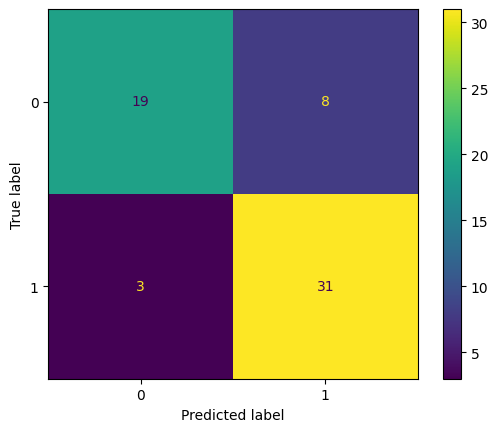

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix

# first train a random forest classifier on the original data
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(x_train,y_train)

y_pred = rf.predict(x_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf, x_test, y_test)
plt.show()

In [21]:
df["output"].value_counts()

1    165
0    138
Name: output, dtype: int64

In [15]:
# generate data using trained model
noise = np.random.normal(0, 1, (165, latent_dim))
sampled_labels = np.zeros(165).reshape(-1, 1)
sampled_labels = keras.utils.to_categorical(sampled_labels,num_classes)

gen_samples = model.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('output',1).columns)

noise_2 = np.random.normal(0, 1, (138, latent_dim))
sampled_labels_2 = np.ones(138).reshape(-1, 1)
sampled_labels_2 = keras.utils.to_categorical(sampled_labels_2,2)

gen_samples_2 = model.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df.drop('output',1).columns)

gen_df_2['output'] = 1
gen_df['output']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

x_train_2 = df_gan.drop('output', 1)
y_train_2 = df_gan['output'].values

5/5 [==============================] - 0s 2ms/step


In [16]:
x_train_2.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,-0.827152,-0.999740,-0.973407,-0.926143,0.743938,-0.274923,0.999960,0.884413,-0.971958,-0.986676,0.977424,-0.990939,0.763021
1,0.997940,0.525807,0.995617,0.988310,-0.962681,-0.228074,-0.014629,-0.993463,-0.838733,0.477194,0.403582,-0.554400,0.231919
2,0.993861,0.760000,-0.520716,-0.127718,-0.988010,-0.253810,0.990019,-0.999665,0.959377,0.985295,-0.942733,0.996073,0.955121
3,0.999708,-0.972539,0.997498,-0.994842,-0.974048,-0.514560,0.935555,-0.999209,-0.998379,0.409141,0.790883,0.854692,-0.257850
4,0.998867,-0.997801,0.329501,-0.199610,-0.043713,-0.136034,-0.967186,-0.183655,-0.559315,0.975302,-0.998975,-0.407816,0.620658


              precision    recall  f1-score   support

           0       0.70      0.96      0.81        27
           1       0.96      0.68      0.79        34

    accuracy                           0.80        61
   macro avg       0.83      0.82      0.80        61
weighted avg       0.85      0.80      0.80        61



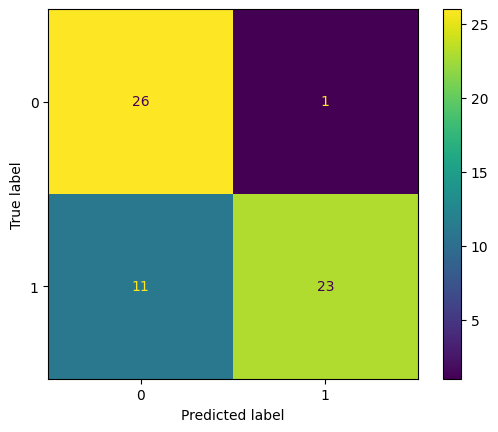

In [17]:
# now train a different instance of random forest classifier with the same parameters on generated data
rf1 = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf1.fit(x_train_2,y_train_2)

y_pred = rf1.predict(x_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf1, x_test, y_test)
plt.show()

## Distance measurement for generated data

In [18]:
generated = scaler.inverse_transform(df_gan.drop("output",1))
generated_df = pd.DataFrame(data=generated,columns = df.drop("output",1).columns)
generated_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,46.866463,0.218048,-0.035951,115.407753,284.759216,0.050750,1.053023,169.871033,-0.129134,-0.104109,2.000659,-0.282294,2.779939
1,63.414761,0.927796,1.992829,148.928253,196.449936,0.067409,0.520373,126.929024,-0.066649,1.592747,1.647627,0.163376,2.455296
2,63.377773,1.036751,0.430478,129.387527,195.139297,0.058258,1.047804,126.787186,0.776698,2.181716,0.819363,1.746281,2.897364
3,63.430794,0.230703,1.994767,114.204903,195.861740,-0.034468,1.019211,126.797607,-0.141526,1.513863,1.885898,1.601943,2.155917
4,63.423161,0.218950,1.306497,128.128754,244.002075,0.100140,0.020289,145.447174,0.064404,2.170132,0.784762,0.313026,2.692918


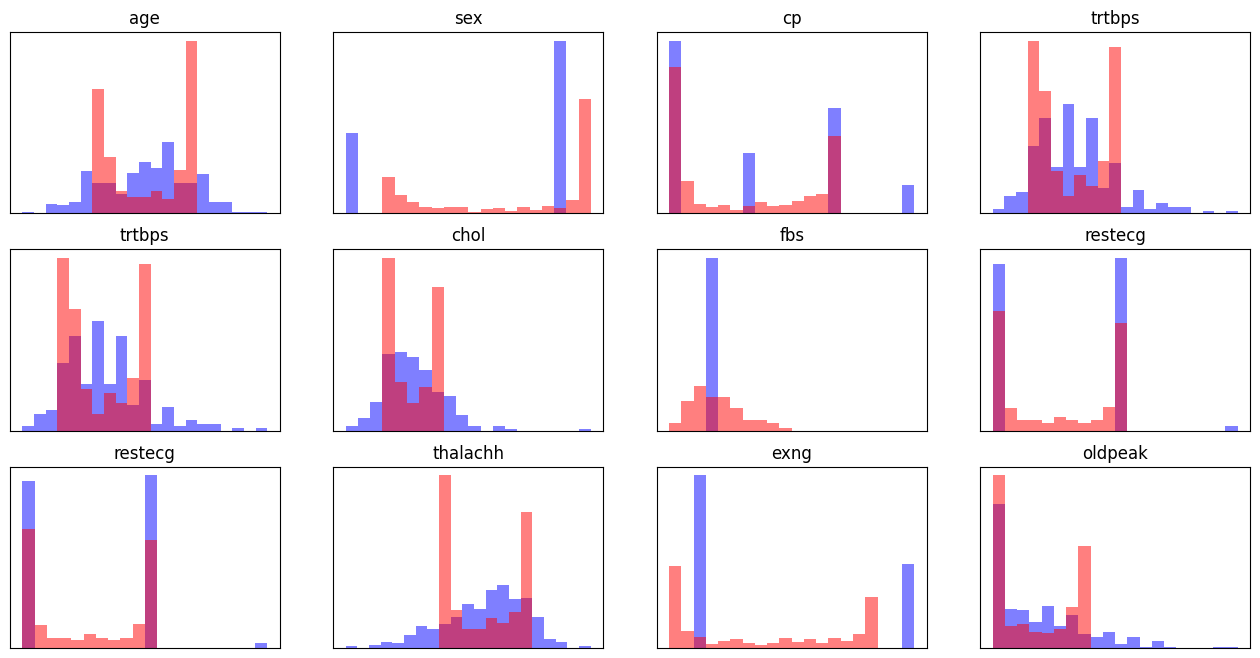

In [19]:
from utils import build_hist
build_hist(df,generated_df,3,4,df.columns[:12],figsize=(16,8))